# Parte 2 – Clusterização e Classificação

Implementar em contêiner na plataforma o modelo de Clusterização e Classificação desenvolvido na disciplina de Machine Learning.

In [53]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Visualizando os dados

In [4]:
loan_default = pd.read_csv('../base/loan_default.csv')
loan_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [5]:
loan_default.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co_applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24932,2019,cf,Male,nopre,type3,p4,l1,nopc,nob/c,...,EQUI,765,EXP,45-54,to_inst,NaN,North,direct,1,NaN
2,25039,2019,cf,Male,nopre,type2,p3,l1,nopc,b/c,...,EQUI,880,EXP,35-44,to_inst,NaN,North,direct,1,NaN
3,25101,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EQUI,880,EXP,45-54,to_inst,NaN,central,direct,1,NaN
4,25110,2019,cf,Male,nopre,type3,p3,l1,nopc,nob/c,...,EQUI,768,EXP,45-54,not_inst,NaN,North,direct,1,NaN


In [6]:
loan_default.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,148670.0,99224.500000,42917.476598,24890.000000,62057.25000,99224.50000,136391.750000,1.735590e+05
year,148670.0,2019.000000,0.000000,2019.000000,2019.00000,2019.00000,2019.000000,2.019000e+03
loan_amount,148670.0,331117.743997,183909.310127,16500.000000,196500.00000,296500.00000,436500.000000,3.576500e+06
rate_of_interest,112231.0,4.045476,0.561391,0.000000,3.62500,3.99000,4.375000,8.000000e+00
Interest_rate_spread,112031.0,0.441656,0.513043,-3.638000,0.07600,0.39040,0.775400,3.357000e+00
Upfront_charges,109028.0,3224.996127,3251.121510,0.000000,581.49000,2596.45000,4812.500000,6.000000e+04
term,148629.0,335.136582,58.409084,96.000000,360.00000,360.00000,360.000000,3.600000e+02
property_value,133572.0,497893.465696,359935.315562,8000.000000,268000.00000,418000.00000,628000.000000,1.650800e+07
income,139520.0,6957.338876,6496.586382,0.000000,3720.00000,5760.00000,8520.000000,5.785800e+05
Credit_Score,148670.0,699.789103,115.875857,500.000000,599.00000,699.00000,800.000000,9.000000e+02


<Axes: >

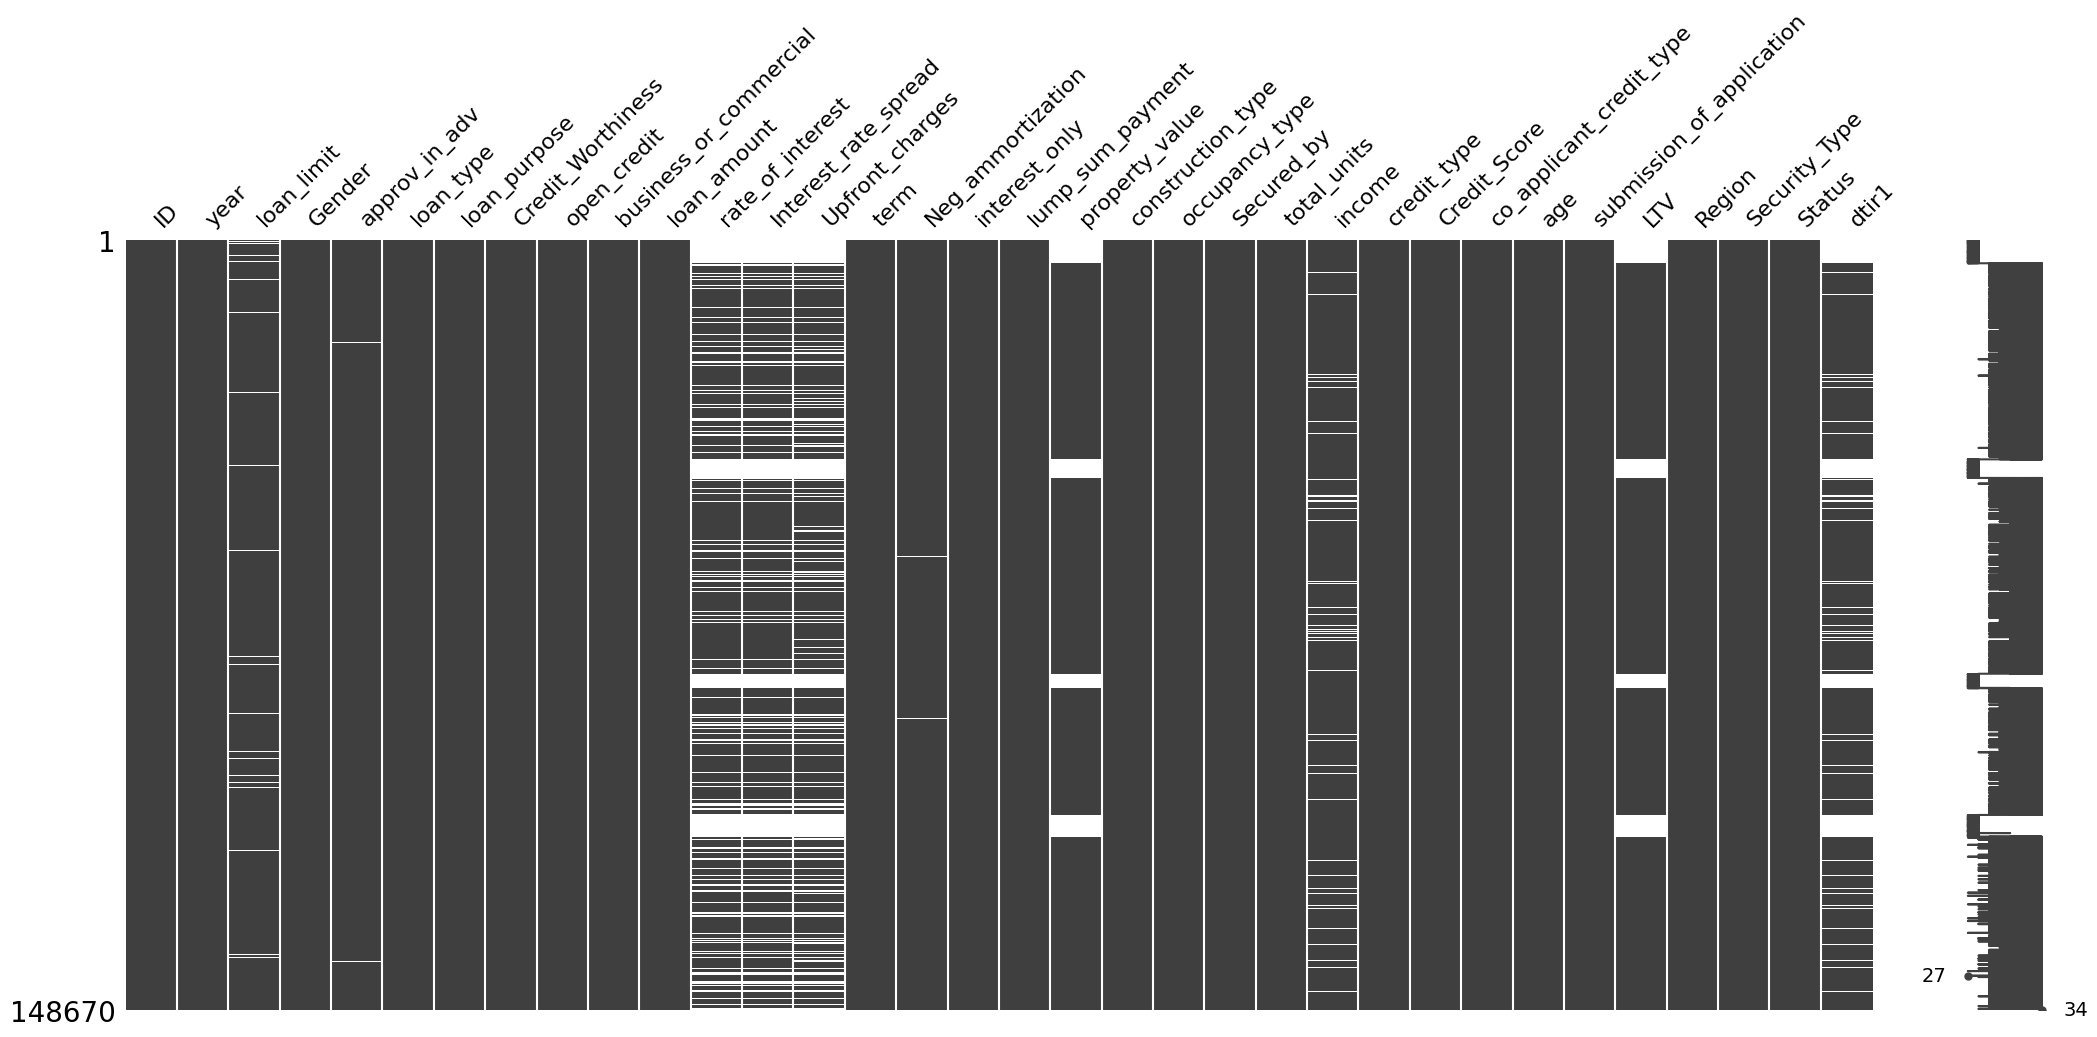

In [7]:
%matplotlib inline
msno.matrix(loan_default)

# Pré processamento

In [8]:
# Dropando colunas que não seráo utilizadas e limpando nulos
df = loan_default.drop(['ID', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'], axis=1)
df = df.dropna(axis=0)

df.shape

(120526, 30)

In [9]:
cat_features = df.select_dtypes(include=['object']).columns.values
num_features = df.select_dtypes(exclude=['object']).columns.values

print('Quantity of category columns', len(cat_features))
print('Quantity of numerical columns', len(num_features))

Quantity of category columns 21
Quantity of numerical columns 9


In [10]:
cat_features

array(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'construction_type', 'occupancy_type',
       'Secured_by', 'total_units', 'credit_type',
       'co_applicant_credit_type', 'age', 'submission_of_application',
       'Region', 'Security_Type'], dtype=object)

# Aplicando Encoder nos dados categóricos

In [374]:
loan_purpose_encoder = LabelEncoder()
loan_purpose_encoder.fit(df['loan_purpose'])

Security_Type_encoder = LabelEncoder()
Security_Type_encoder.fit(df['Security_Type'])

age_encoder = LabelEncoder()
age_encoder.fit(df['age'])

Region_encoder = LabelEncoder()
Region_encoder.fit(df['Region'])

df['loan_purpose_encoded'] = loan_purpose_encoder.transform(df['loan_purpose'])
df['Security_Type_encoded'] = Security_Type_encoder.transform(df['Security_Type'])
df['age_encoded'] = age_encoder.transform(df['age'])
df['Region_encoded'] = Region_encoder.transform(df['Region'])

In [375]:
X_columns = [
    'loan_purpose_encoded',
    'Security_Type_encoded',
    'age_encoded',
    'Region_encoded',
]

for feature in num_features:
    X_columns.append(feature)

X_columns.pop(-2) # Remover Status

with open("docker/features_used.txt", "w") as file:
    file.write(', '.join(X_columns))

In [376]:
X = df[X_columns].dropna()
X_columns

['loan_purpose_encoded',
 'Security_Type_encoded',
 'age_encoded',
 'Region_encoded',
 'year',
 'loan_amount',
 'term',
 'property_value',
 'income',
 'Credit_Score',
 'LTV',
 'dtir1']

# Escalonando os dados

In [377]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Usando o Elbow Method para encontrar o melhor número de Ks

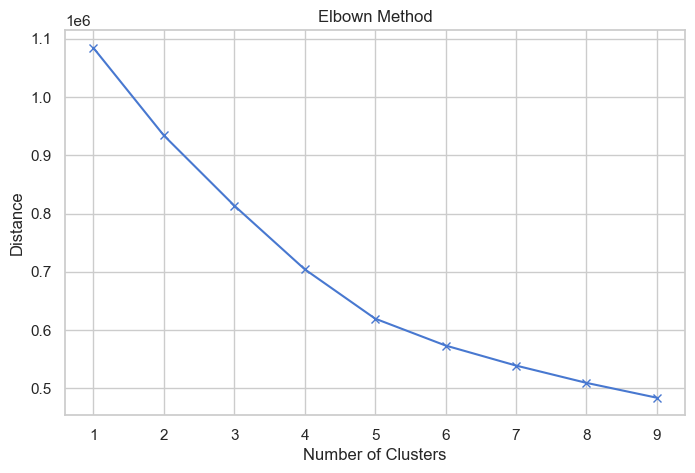

In [301]:
plt.figure(figsize=(8, 5))

K = range(1,10)
sum_of_squared_distances=[]
for k in K:
  km = KMeans(n_clusters=k, n_init=10)
  km = km.fit(X_scaled)
  sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.title('Elbown Method')
plt.show()

# Treinando o modelo

In [378]:
km = KMeans(n_clusters=5, random_state=42)
km = km.fit(X_scaled)

# Explorando o retorno do modelo

In [379]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [380]:
df_reduced = pd.DataFrame(X_pca)
df_reduced.columns = ['Attr1', 'Attr2']
df_reduced['Labels'] = km.labels_

df_reduced.head()

,Attr1,Attr2,Labels
0,4.190527,-0.152188,4
1,3.968907,-0.174534,4
2,3.186040,0.136210,4
3,0.178688,-2.222131,1
4,-0.053599,-1.928933,1


<Axes: xlabel='Attr1', ylabel='Attr2'>

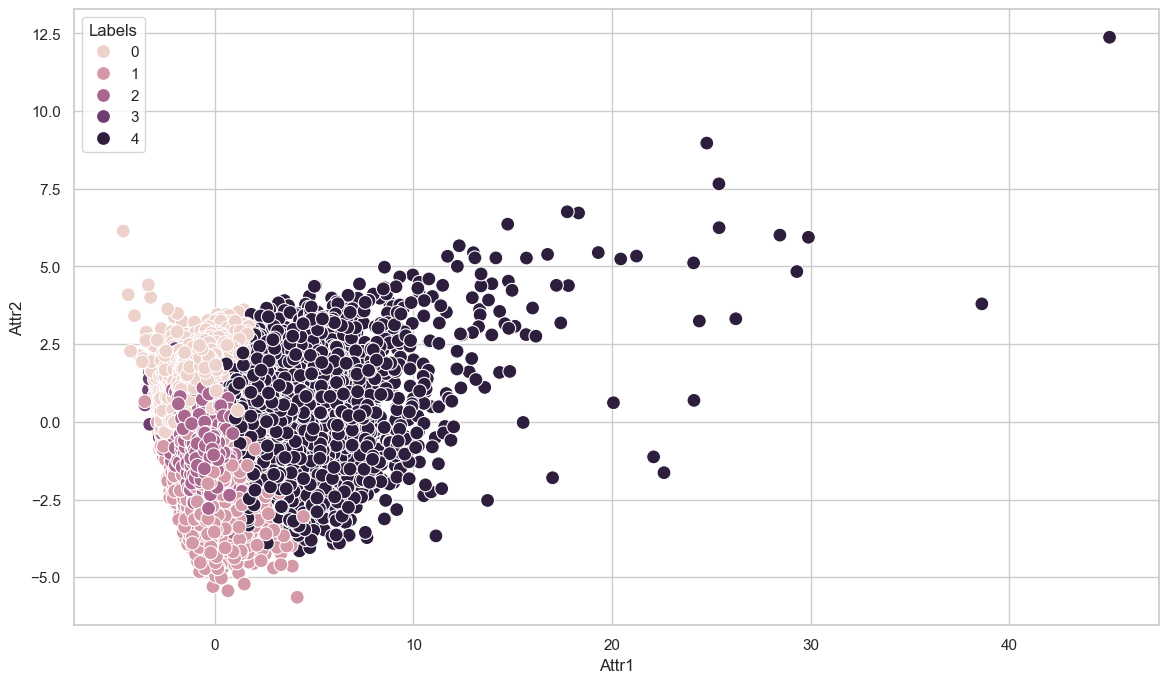

In [381]:
plt.figure(figsize=(14,8))
sns.set(style="whitegrid", palette="muted")
sns.scatterplot(x="Attr1", y="Attr2", hue="Labels", s=100, data=df_reduced)

# Identificando a propensão a inadinplência de cada grupo

In [382]:
df_reduced['Status'] = df['Status']
df_reduced['Credit_Score'] = df['Credit_Score']
df_reduced['Region'] = df['Region']
df_reduced['age'] = df['age']

df_reduced.dropna(inplace=True)
df_reduced.reset_index(drop=True, inplace=True)

# Extracting Persona

In [392]:
def get_score_description(score):
    if score < 600:
        return "low score"
    elif score < 700:
        return "medium score"
    elif score >= 700:
        return "high score"

def evaluate_label(label):
    df_filtered = df_reduced.query("Labels == @label")
    is_defaulted = df_filtered['Status']
    if len(is_defaulted) == 0:
        return { 'label': label, 'total': len(is_defaulted) }

    defaulted_ratio = np.divide(is_defaulted.sum(), len(is_defaulted))
    return { 
        'label': label, 
        'total': len(is_defaulted), 
        'defaulted': is_defaulted.sum(),
        'defaulted_ratio': defaulted_ratio, 
        'mean_credit_score_label': df_filtered['Credit_Score'].mean(),
        'mean_credit_score_defaulted': df_filtered.query("Status == 1")['Credit_Score'].mean(),
    }

def get_persona(row):
    return f"A person with a {get_score_description(row['Credit_Score'])}, living in the {row['Region']}, is around {row['age']} years old."

In [385]:
df_reduced.columns

Index(['Attr1', 'Attr2', 'Labels', 'Status', 'Credit_Score', 'Region', 'age'], dtype='object')

In [394]:
df_evaluate_defaulted = pd.DataFrame()

for label in range(5):
    df_evaluate_defaulted = pd.concat([df_evaluate_defaulted, pd.DataFrame(evaluate_label(label), index=[0])])

df_evaluate_defaulted = df_evaluate_defaulted[['label', 'defaulted_ratio', 'mean_credit_score_label', 'mean_credit_score_defaulted']]
df_evaluate_defaulted.to_csv('docker/stats_label.csv', index=False)

df_evaluate_defaulted

,label,defaulted_ratio,mean_credit_score_label,mean_credit_score_defaulted
0,0,0.150849,699.698938,700.003894
0,1,0.162222,698.804615,699.813943
0,2,0.156646,699.181327,699.109146
0,3,0.272727,693.818182,673.833333
0,4,0.152642,699.970493,705.428886


In [388]:
get_persona(df.iloc[0])

'A person with a high score, living in the North, is around 45-54 years old.'

# Salvando modelo

In [389]:
# Salvando Encoders
pickle.dump(loan_purpose_encoder, open('docker/loan_purpose_encoder.pkl', 'wb'))
pickle.dump(Security_Type_encoder, open('docker/Security_Type_encoder.pkl', 'wb'))
pickle.dump(age_encoder, open('docker/age_encoder.pkl', 'wb'))
pickle.dump(Region_encoder, open('docker/Region_encoder.pkl', 'wb'))

# Salvando Scaler
pickle.dump(scaler, open('docker/scaler.pkl', 'wb'))

# Salvando modelo
pickle.dump(km, open('docker/model.pkl', 'wb'))

# Guardar os dados para teste da API

In [391]:
request_sample = df[['loan_purpose',
 'Security_Type',
 'age',
 'Region',
 'year',
 'loan_amount',
 'term',
 'property_value',
 'income',
 'Credit_Score',
 'LTV',
 'dtir1']].iloc[0].to_json()

with open("docker/request_sample.json", "w") as file:
    file.write(request_sample)